# Assignment 05

## Recommender Systems 

## CSCI E-108

### Steve Elston

## Introduction 

Recommender algorithms are widely used in commerce. Further, the basic algorithms have found applications in other areas. In this Assignment you gain some experience working with recommender data, the collaborative filtering algorithm and some versions of the nonnegative matrix factorization algorithm.           

This Assignment uses the Python [Surprise](https://surprise.readthedocs.io/en/stable/index.html) package a Scikit for recommender system experimentation. This package is in maintenance mode, but is still useful for learning recommender concepts. If you have not previously installed Surprise you will need to install it. Generally, the best way to install this older package is to run the command below from a command prompt on your system. If you have difficulty, you can refer to [this Stackoverflow thread](https://stackoverflow.com/questions/62042317/cannot-install-scikit-surprise-on-my-jupyter-notebook).      

> **Computational note:** The Surprise package was never intended as a production recommender system. If you want to explore options for production scalable recommender systems some options include:   
> 1. The Neo4J graph database contains extensive support for enterprise recommendation systems. You can see a tutorial introduction [here](https://neo4j.com/developer/cypher/guide-build-a-recommendation-engine/).   
> 2. The major cloud machine learning platforms, such as Keras and PyTorch, have increasing massive scale support for recommendation algorithms. You can find some getting started information for both [Kera](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) and [PyTorch](https://pytorch.org/blog/introducing-torchrec/).

Execute the code in the cell below to import the packages you will need for this assignment. 

In [1]:
from surprise.prediction_algorithms.matrix_factorization import SVD, NMF
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load and Explore the Dataset   

In this Assignment you will work with the MovieLens 100k dataset. This dataset includes a total of 100,000 movie ratings from IMDB. 

Before working with recommender algorithms, you will explore these data. Exploration of data is an essential step in any data mining process.     

The code in the cell below loads the dataset and splits it into training and testing datasets. Execute this code. If you are asked if you want to download the data you must answer y. 

In [2]:
## Load the movielens-100k dataset 
## Answer y if you are asked to download the dataset
movie_lense_data = Dataset.load_builtin('ml-100k')

## Split the dataset into training and test subsets.
np.random.seed(4517)
ml_trainset, ml_testset = train_test_split(movie_lense_data, test_size=0.20)

Before experimenting with the recommender algorithms we will explore the data. As a first step of the execute the code in the cell below to print some characteristics of the training dataset.  

In [3]:
print('For training dataset:')
print("Number of users = {}".format(ml_trainset.n_users))
print("Number of items = {}".format(ml_trainset.n_items))
print("Number of ratings = {}".format(ml_trainset.n_ratings))

For training dataset:
Number of users = 943
Number of items = 1654
Number of ratings = 80000


You can see some basic characteristics of the training dataset. If these data were represented as a rectangular table or matrix they would require, over 1.5 million, and at least that many bytes. In practice, a more efficient representation is used. 

The Surprise package, like all real-world recommender software, uses a space efficient representation. The `ur` attribute of the Surprise data object contains a dictionary with the recommender data. The keys of the dictionary are numeric identifiers of the users. The values of this key-value pairs are a list of tuples. The tuples are key-value pairs, with the key being the item identifier and the rating. In summary, there is a hashed user key to item key-value pairs. This nesting of key-value pairs is necessary since Python dictionaries only support a single hashed key per value.        

The code in the cell below prints the list of key-value pairs for a single user key. There are multiple item identifier, rating, tupples for user 5. Execute this code and examine the results.   

In [4]:
## Print the product-rating tupples in the 'ur' attribute of the data object from user 6
print(f"The number of recommendations = {len(ml_trainset.ur[5])}")
ml_trainset.ur[5]

The number of recommendations = 32


[(5, 4.0),
 (339, 4.0),
 (919, 5.0),
 (169, 4.0),
 (574, 2.0),
 (49, 2.0),
 (563, 2.0),
 (144, 5.0),
 (859, 3.0),
 (650, 1.0),
 (4, 4.0),
 (507, 3.0),
 (75, 2.0),
 (289, 2.0),
 (593, 4.0),
 (348, 2.0),
 (160, 4.0),
 (47, 5.0),
 (34, 3.0),
 (904, 2.0),
 (216, 3.0),
 (407, 3.0),
 (322, 2.0),
 (477, 1.0),
 (349, 3.0),
 (557, 4.0),
 (321, 3.0),
 (372, 3.0),
 (955, 2.0),
 (276, 5.0),
 (1069, 4.0),
 (616, 4.0)]

User 5 has only rated 32 items of 1647 total items.     

> **Exercise 05-1:** To gain some understanding of the nature of the ratings, in the cell below create and execute code to compute and print two summary statistics in decimal fraction format. Use the attributes of the training dataset to extract the required parameters. See the foregoing example for an example of accessing the attributes of the data object.        
> 1. Fraction of all items rated by user 5. 
> 2. The fraction of possible item-user pairs in the utility matrix that have non-null values.    

In [5]:
# Items rated by user 5
num_items_rated_by_user_5 = len(ml_trainset.ur[5])

# Total items
total_items = ml_trainset.n_items

# Total number of users
total_users = ml_trainset.n_users

# Total number of ratings
total_ratings = ml_trainset.n_ratings

# 1. Fraction of all items rated by user 5
fraction_items_rated_by_user_5 = num_items_rated_by_user_5 / total_items

# 2. Fraction of possible item-user pairs with non-null values
fraction_non_null_item_user_pairs = total_ratings / (total_users * total_items)

# Print results
print(f"Fraction of all items rated by user 5: {fraction_items_rated_by_user_5:.4f}")
print(f"Fraction of possible item-user pairs with non-null values: {fraction_non_null_item_user_pairs:.4f}")

Fraction of all items rated by user 5: 0.0193
Fraction of possible item-user pairs with non-null values: 0.0513


> Q1. Given that real-world online catalog (products, videos, music, etc.) can contain millions of items, do you think these fractions for an individual user and the average user are realistic or too high? 

> **Answer:** Both are too high. The interaction between any user and item should be rare given the large numbers of both, resulting in a sparse matrix and 2% of all items rated by 1 user, and 5% for all possible pairs seems very high. However in this dataset there are only around 900 users and 1,600 items, so we find the statistics reasonable given the dataset.

> 3. Create two lists with the following values, a) list named `mean_ratings` containing the mean rating of each user, and b) a list named `number_ratings` that contains the count of ratings for each user. The user ratings are represented with a Python dictionary, with the user identifier as key, in the `ur` attribute of the training dataset. You can extract the keys (user identifiers) with the `keys` method.  
> 4. Once you have completed your code, execute the code in the cell below to display the histograms.  

Mean ratings: [3.574324324324324, 4.003125, 3.642857142857143, 3.8647686832740216, 3.626865671641791]
Number of ratings: [148, 320, 56, 281, 201]


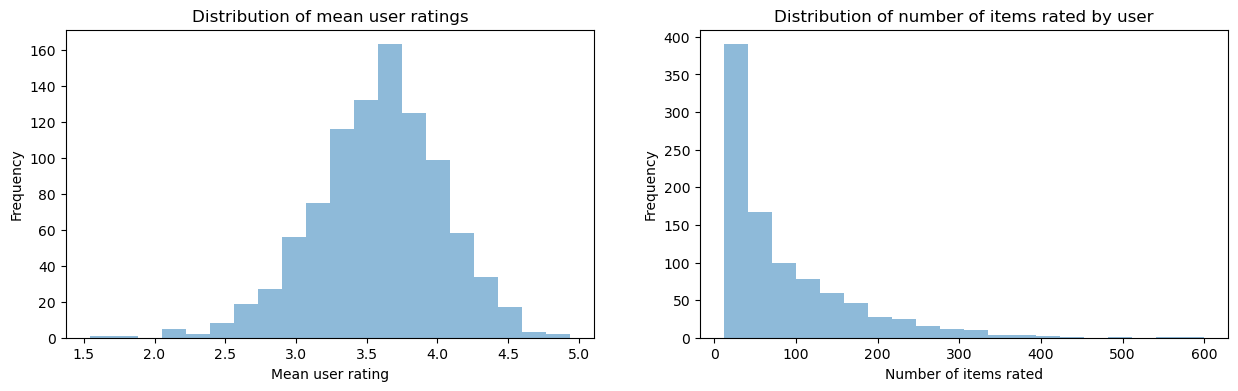

In [6]:
# Initialize lists to store mean ratings and number of ratings for each user
mean_ratings = []
number_ratings = []

# Access the user identifiers using the keys method
user_ids = ml_trainset.ur.keys()

# Iterate over each user identifier
for user_id in user_ids:
    # Extract the ratings from the (item_id, rating) tuples for the current user
    user_ratings = [rating for item_id, rating in ml_trainset.ur[user_id]]
    
    # Calculate the mean rating for the user
    mean_rating = sum(user_ratings) / len(user_ratings)
    
    # Append the mean rating to the mean_ratings list
    mean_ratings.append(mean_rating)
    
    # Append the number of ratings to the number_ratings list
    number_ratings.append(len(user_ratings))

# Print five entries as sanity check
print(f"Mean ratings: {mean_ratings[:5]}")
print(f"Number of ratings: {number_ratings[:5]}")

## Create a histograms of the results
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(mean_ratings, bins=20, alpha=0.5) 
_=ax[0].set_xlabel('Mean user rating')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of mean user ratings')
_=ax[1].hist(number_ratings, bins=20, alpha=0.5) 
_=ax[1].set_xlabel('Number of items rated')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of number of items rated by user')

> Provide short answers to the following questions:   
> Q2. Is the distribution of the mean user ratings a bit skewed? What does this skew tell us?   
> Q3. Notice the rapid decay in the frequency of items rated by users. What does this long tail tell you about user behavior?  
> **End of exercise.**

> **Answers:**   
> Q2. The skew tells us that i) there is a bias towards leniency and ii) more satisfied than unsatified users tend to rate items.       
> Q3. Users typically don't rate all items and only a small percentage of items purchased, or it could be that average purchases are also very few with many unique users.    

## Baseline Only Model

One possible answer to the cold start problem is to use a **baseline only** model. In this model we just use the average or baseline values for users or items to predict ratings. This same approach can be applied to users who consume an item, but provide no rating.

> **Exercise 05-2:** You will now create and evaluate a baseline recommender model. Do the following:   
> 1. Instantiate a [surprise.prediction_algorithms.baseline_only.BaselineOnly](https://surprise.readthedocs.io/en/stable/basic_algorithms.html) model object and it with the `fit` method using the `ml_trainset` as the argument. Name your model object `baseline_model`.  
> 2. Compute the recommender predictions with the `test` method using the `ml_testset` as the argument.   
> 3. Compute and print the RMSE using [surprise.accuracy.rmse](https://surprise.readthedocs.io/en/stable/accuracy.html) and MAE using [surprise.accuracy.mae](https://surprise.readthedocs.io/en/stable/accuracy.html) with the predictions as the argument in both cases.  

In [7]:
np.random.seed(864)

## Instantiate the model object and fit to the training data  
baseline_model = BaselineOnly()
baseline_model.fit(ml_trainset)

# Compute the predicitons from the model 
predictions = baseline_model.test(ml_testset)

# Compute some model performance statistics
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


Estimating biases using als...
RMSE: 0.9371
MAE:  0.7421


> Q1. Does the accuracy performance of this model seem good given its simplicity?   

> **Answer:**  Yes, seems reasonable given the simplicity. However, when scores are out of 5 and distributed closed around a mean of 3.5-4, RMSE of 0.94 and MAE of 0.74 are quite large and we could do better with more detailed models.

> 4. Execute the code in the cell below to display histograms of the item and user biases. 

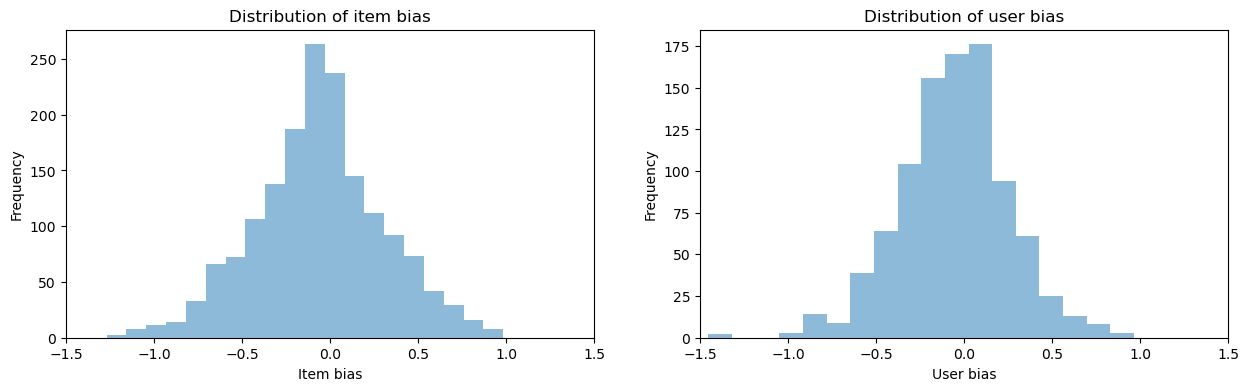

In [8]:
## plot the biases
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(baseline_model.bi, bins=20, alpha=0.5) 
_=ax[0].set_xlabel('Item bias')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of item bias')
_=ax[0].set_xlim(-1.5,1.5)
_=ax[1].hist(baseline_model.bu, bins=20, alpha=0.5) 
_=ax[1].set_xlabel('User bias')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of user bias')
_=ax[1].set_xlim(-1.5,1.5)

> Q2. These bias values are approximately Normally distributed, but with somewhat heavy tails. Examine the range of these biases. What does the fact that these ranges are small compared to the range of ratings tell you about the magnitude of the bias adjustments?      

> **Answer:**   The ranges of item and user biases are small compared to the range of ratings indicates that these biases are minor adjustments that enhance the baseline prediction without drastically changes, and likely reflect the real world ground truth better. It gives more confidence to the baseline in solving the cold start problem.

> 5. Ideally, the biases should be uniformly distributed with identifier. In other words, statistically independent of the identifiers. In other words, **homoskedastic**. Execute the code to display the relationship. 

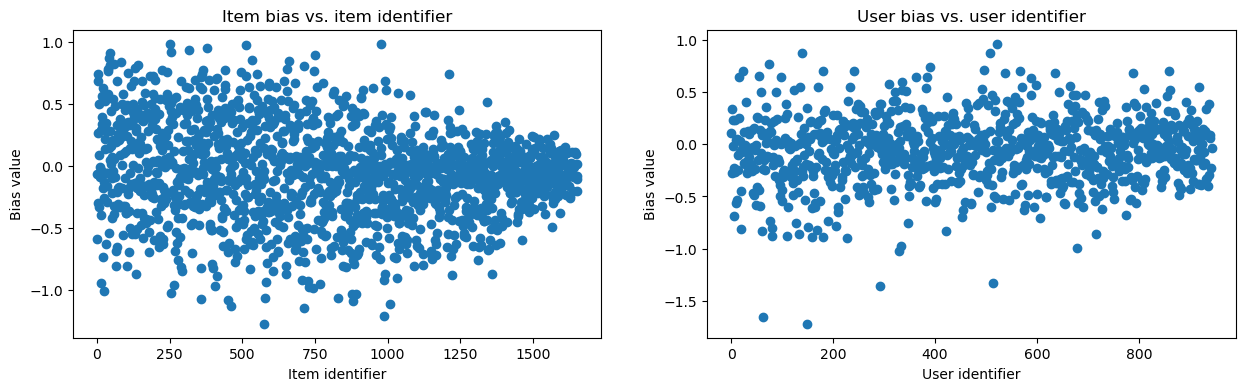

In [9]:
## plot the biases
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].scatter(range(len(baseline_model.bi)), baseline_model.bi) 
_=ax[0].set_xlabel('Item identifier')
_=ax[0].set_ylabel('Bias value')
_=ax[0].set_title('Item bias vs. item identifier')
_=ax[1].scatter(range(len(baseline_model.bu)), baseline_model.bu) 
_=ax[1].set_xlabel('User identifier')
_=ax[1].set_ylabel('Bias value')
_=ax[1].set_title('User bias vs. user identifier')

> Q3. Does the distribution of the biases look largely uniform with item identifier or not?    
> Q4. Does the distribution of the biases look largely uniform with user identifier or not?   

> **Answers:**   
> Q3. Largely, but bias seem to decrease as the item idenfitier increases towards item idenfifiers that are 1000+.    
> Q4. Yes, with a few negative outliers greater in magnitude than positive outliers.    

## Collaborative Filtering Model  

The collaborative filtering model is an unsupervised learning model using similarity item-item or user-user similarity measures. Items with the highest similarity measures are recommended.  

> **Exercise 05-3:** You will now create and evaluate a baseline recommender model. Do the following:   
> 1. Instantiate a [surprise.prediction_algorithms.knns.KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) model object and it with the `fit` method using the `ml_trainset` as the argument. Name your model object `collaborative_filter_model`.  
> 2. Compute the recommender predictions with the `test` method using the `ml_testset` as the argument.   
> 3. Compute and print the RMSE using `surprise.accuracy.rmse and MAE using `surprise.accuracy.mae` with the predictions as the argument in both cases.  

In [10]:
np.random.seed(258)
## Instantiate the model object and fit to the training data  
collaborative_filter_model = KNNBasic()
collaborative_filter_model.fit(ml_trainset)

## Compute the predicitons from the model 
predictions_collaborative = collaborative_filter_model.test(ml_testset)

# Compute some model performance statistics
rmse_collaborative = accuracy.rmse(predictions_collaborative)
mae_collaborative = accuracy.mae(predictions_collaborative)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9676
MAE:  0.7636


> Provide short answers to the following questions:     
> Q1. Compare the performance of this model to the baseline model. Is it better or worse?     
> Q2. Keeping in mind that the rating sampling is more dense that a real-world example, what does this tell you about the effectiveness of a baseline model vs. the model based on similarity.    
  

> **Answers:**       
> Q1. The model is slightly worse in terms of RMSE and MAE levels, which are slightly higher than baseline.          
> Q2. In a denser rating dataset like this one, the baseline model, which uses simple average ratings and biases, proves to be more effective than the similarity-based model. However, in sparser datasets where individual user-item interactions are limited, collaborative filtering models may outperform baseline models by leveraging similarities between users or items to make more accurate predictions.

> 4. The distribution of the similarities gives insight into the behavior of the model. Execute the code in the to display the histogram of the user-user similarity measures.   

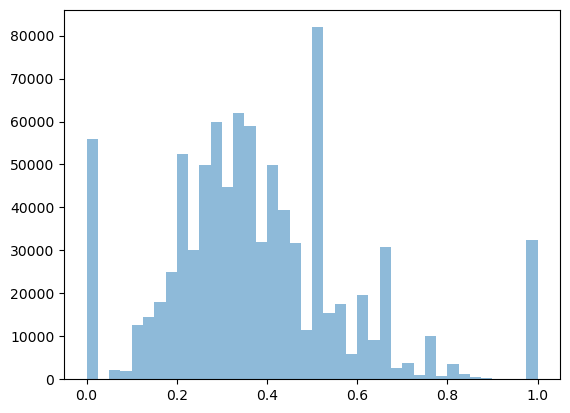

In [11]:
_=plt.hist(collaborative_filter_model.sim.flatten(), bins=40, alpha=0.5)

> Q3. Examine the plot. Notice there are a number of similarities which are or are close to 0 or 1, and another spike around 0.5. Is the distribution of these similarities skewed? If so, what does this skew tell you about how strong a predictor similarity can be in this case.    
> **End of exercise.**

> **Answer:**    
> Q1. The model is slightly worse in terms of RMSE and MAE levels, which are slightly higher than baseline.          
> Q2. In a denser rating dataset like this one, the baseline model, which uses simple average ratings and biases, proves to be more effective than the similarity-based model. However, in sparser datasets where individual user-item interactions are limited, collaborative filtering models may outperform baseline models by leveraging similarities between users or items to make more accurate predictions.

## Matrix Factorization Methods   

Matrix factorization algorithms are generally considered to be the state of the art for recommenders. The matrix factorization methods find a set of latent (non-observable) factor variable values, which are used to compute rating estimates. Additionally, user and item rating bias adjustments are applied.    

> **Exercise 05-4:** You will now create and evaluate a baseline recommender model. Do the following:   
> 1. Instantiate a [surprise.prediction_algorithms.matrix_factorization.SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) model object, using 10 factors, and it with the `fit` method using the `ml_trainset` as the argument. Name your model object `svd_model`.  
> 2. Compute the recommender predictions with the `test` method using the `ml_testset` as the argument.   
> 3. Compute and print the RMSE using `surprise.accuracy.rmse` and MAE using `surprise.accuracy.mae` with the predictions as the argument in both cases.  

In [12]:
np.random.seed(9741)
## Instantiate the model object and fit to the training data  

# Instantiate the SVD model object with 10 factors
n_factors=10
svd_model = SVD(n_factors)

# Fit the model to the training data
svd_model.fit(ml_trainset)


## Compute the predicitons from the model 
predictions_svd = svd_model.test(ml_testset)

# Compute some model performance statistics
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)


RMSE: 0.9304
MAE:  0.7337


> Provide short answers to the following questions:   
> Q1. Compare the performance of this model to the baseline model. Is it better or worse?     
> Q2. Keeping in mind that the rating sampling is more dense that a real-world example, what does this tell you about the effectiveness of a baseline model vs. the model based on latent factors.    


> **Answers:**       
> Q1. The SVD-based matrix factorization model outperforms the baseline model slightly, given lower RMSE and MAE.
> 
> Q2. In real-world examples with sparser rating data, the effectiveness of a model based on latent factors may be even more pronounced. Sparse datasets benefit from the ability of matrix factorization models to capture underlying patterns and correlations between users and items, which may not be apparent from the raw data. So overall, model based on latent factors may outperform in the real-world as well.

> 4. The distribution of the item and factor values gives insight into the behavior of the model. Execute the code in the to display the histograms of the factors for items and users.     

Shape of item factor matrix: (1654, 10)
Shape of user factor matrix: (943, 10)


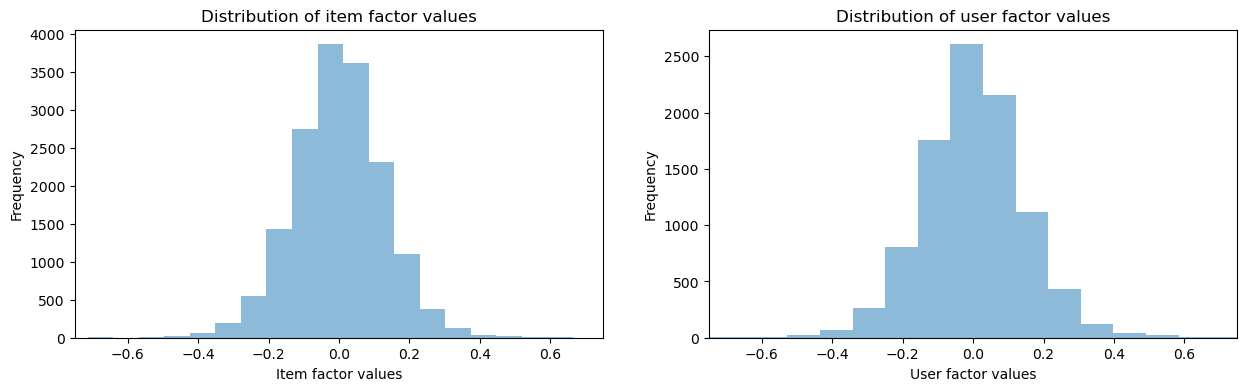

In [13]:
print('Shape of item factor matrix: {}'.format(svd_model.qi.shape))
print('Shape of user factor matrix: {}'.format(svd_model.pu.shape))

## Create a histograms of the factor values
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(svd_model.qi.flatten(), bins=20, alpha=0.5) 
_=ax[0].set_xlabel('Item factor values')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of item factor values')
_=ax[0].set_xlim(-.75,.75)
_=ax[1].hist(svd_model.pu.flatten(), bins=20, alpha=0.5) 
_=ax[1].set_xlabel('User factor values')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of user factor values')
_=ax[1].set_xlim(-.75,.75)

> 5. Finally, you will compute the compression of the factor model compared to a model using the full utility matrix. 

In [14]:
## Calculation of compression of factor model   
n_reviews = 0
for key in ml_trainset.ur.keys(): 
    n_reviews += len(ml_trainset.ur[key])
print(f"Total number of reviews = {n_reviews}")
utility_bytes = 8*n_reviews + 4*ml_trainset.n_users
print(f"Bytes for all review tuples = {utility_bytes}")

P_size = n_factors * ml_trainset.n_users
Q_size = n_factors * ml_trainset.n_items
print(f"Values in P = {P_size}")
print(f"Values in Q = {Q_size}")
PQ_bytes = 4 * (P_size + Q_size)
print(f"Total bytes for P + Q = {PQ_bytes}")

compression_ratio = utility_bytes / PQ_bytes
print(f"Compression for factor model = {compression_ratio}")

Total number of reviews = 80000
Bytes for all review tuples = 643772
Values in P = 9430
Values in Q = 16540
Total bytes for P + Q = 103880
Compression for factor model = 6.197266076241817


> Provide short answers to the following questions:     
> Q3. Examine the distribution of the factor values. Compare these values to the distribution of baseline or bias values for the Baseline model. What do the differences in the range of values tell you about the effect of subtracting the bias terms before computing the factor values?     
> Q4. Notice the dimensions of factor matrices computed, Q, P. Is this representation compact compared to the original data set, and why?     
> **End of exercise.**

> **Answers:**   
> Q3. The factor values (P and Q) typically have a wider range compared to the baseline or bias values used in models like the Baseline model, due to subtracing the bias terms (with wider range) before computing the factor values. This allows the model to learn more nuanced representations of users and items, leading to better predictions.

> Q4. The dimensions of the factor matrices (P and Q) are significantly smaller than the dimensions of the original utility matrix. In the provided example, P has 9430 values and Q has 16540 values, resulting in a total of 25970 values for both matrices. Compared to the original dataset with 80000 reviews, the representation using factor matrices is much more compact. This compact representation is achieved by capturing the essential information about users and items in the factors, thus reducing the dimensionality of the data while preserving the important characteristics necessary for making accurate predictions.  

#### Copyright 2021, 2022, 2023, Stephen F Elston. All rights reserved. 